# Introducción

La predicción temprana de accidentes cerebrovasculares es un problema crítico dentro del ámbito de la salud pública. Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular constituye la segunda causa de muerte a nivel mundial y representa aproximadamente el 11% del total de fallecimientos globales. La posibilidad de anticipar estos eventos a partir de información clínica y demográfica habilita herramientas de prevención e intervención temprana.

En este trabajo práctico se desarrolla un modelo de aprendizaje automático orientado a predecir la probabilidad de que un paciente sufra un accidente cerebrovascular, utilizando como insumo el Stroke Prediction Dataset publicado en Kaggle. El objetivo es explorar las variables disponibles, realizar el preprocesamiento necesario, comparar distintas alternativas de modelado y finalmente seleccionar un algoritmo que permita obtener un desempeño robusto y clínicamente útil.

Fuente del dataset:
Federico Soriano, Stroke Prediction Dataset, Kaggle (2021).
Disponible en: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## Miembros del grupo
- Maximiliano Christener
- Ronald Uthurralt
- Juan Pablo Skobalski
- Luis Díaz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostClassifier
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline  # para aplicar SMOTE en el pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, make_scorer, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns


# Esta biblioteca tiene como objetivo ocultar warnings cuando se ejecuta precision_recall_curve
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [ ]:
def find_threshold(y_true, y_proba, beta=2, n_thresholds=200):
    """
    Busca el threshold óptimo que maximiza F-beta (por defecto F2).
    """
    
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    scores = []
    
    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        score = fbeta_score(y_true, y_pred_thr, beta=beta)
        scores.append(score)
    
    best_idx = int(np.argmax(scores))
    best_threshold = thresholds[best_idx]
    best_fbeta = scores[best_idx]
    
    return best_threshold, best_fbeta

El dataset contiene información de pacientes, tanto datos demográficos como factores de riesgo clínicos. Cada fila representa un individuo y cada columna un atributo relevante para la predicción. Las variables principales son:

Variables demográficas:

* gender: género del paciente
* age: edad del paciente
* ever_married: si alguna vez estuvo casado
* work_type: tipo de ocupación
* Residence_type: tipo de residencia (urbana o rural)

Variables clínicas:

* hypertension: presencia de hipertensión
* heart_disease: presencia de enfermedad cardíaca
* avg_glucose_level: nivel promedio de glucosa en sangre
* bmi: índice de masa corporal

Hábitos y estilo de vida:
* smoking_status: categoría de consumo de tabaco

Variable objetivo:

* stroke: indica si el paciente sufrió un accidente cerebrovascular (1) o no (0)

El dataset presenta un desbalance significativo, con un porcentaje muy bajo de casos positivos (5%), lo cual condiciona el tipo de modelos y métricas a utilizar.


# EDA

In [3]:
file_path = "data/healthcare-dataset-stroke-data.csv"

df = pd.read_csv(file_path)

In [4]:
# Configuracion general de graficos
sns.set(style="whitegrid", palette="deep", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nInformación general:")
df.info()

print("\nValores faltantes por columna:")
print(df.isna().sum())


print(df['work_type'])

Dimensiones del dataset: (5110, 12)

Primeras filas:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Valores faltantes por columna:
id                     0
gender                 0
age                    0
hypertension           0
hea

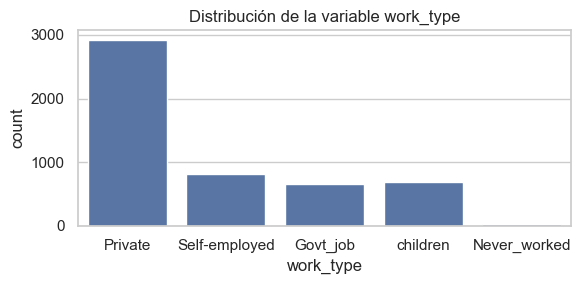

In [6]:
plt.figure(figsize=(6, 3))
sns.countplot(x='work_type', data=df)
plt.title('Distribución de la variable work_type')
plt.tight_layout()
plt.show()

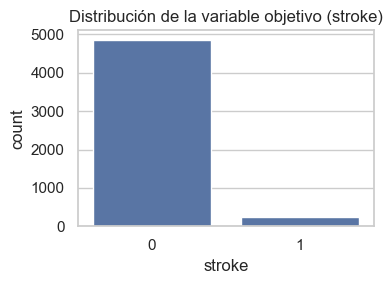

In [7]:
plt.figure(figsize=(4, 3))
sns.countplot(x='stroke', data=df)
plt.title('Distribución de la variable objetivo (stroke)')
plt.tight_layout()
plt.show()

### Distribucion de edad, nivel de glucosa y BMI


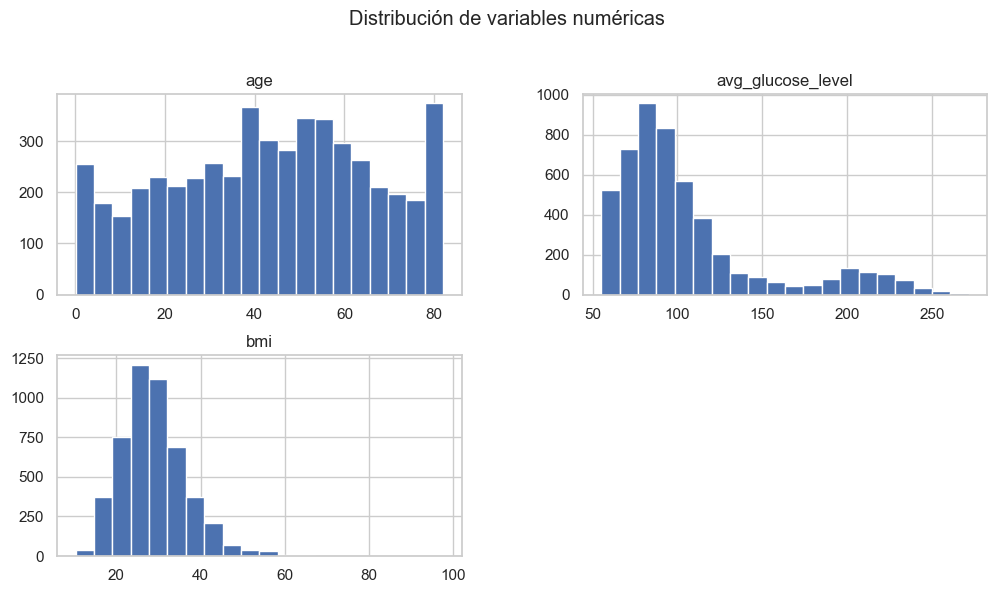

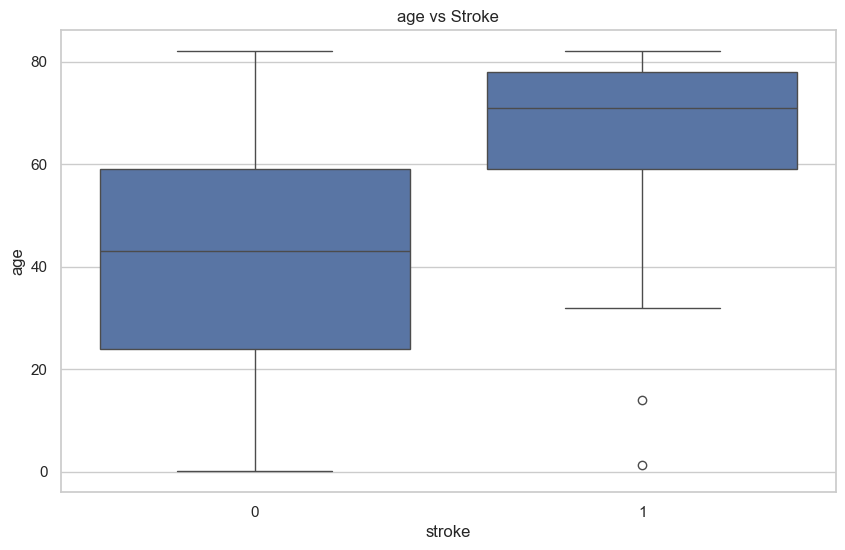

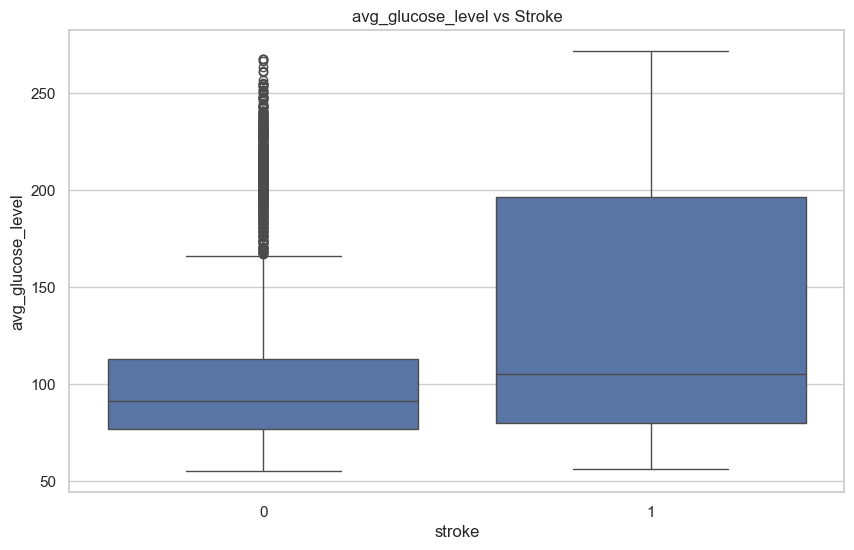

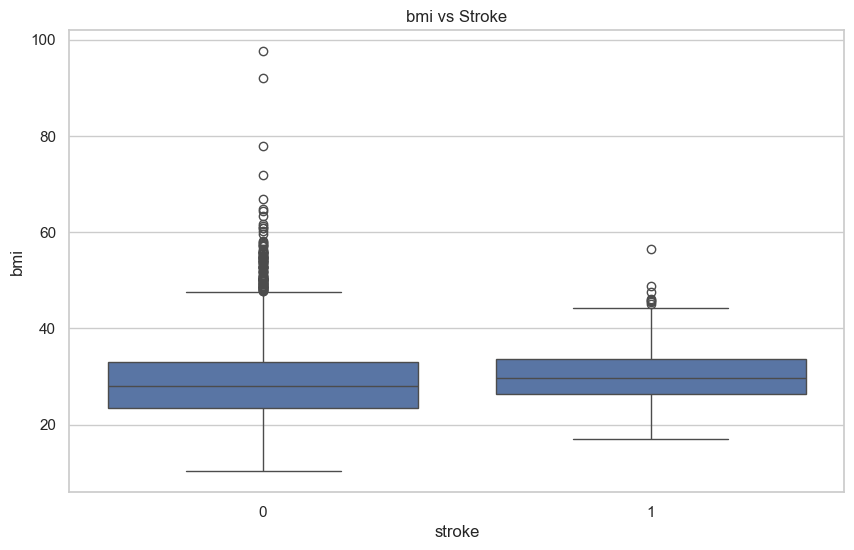

In [8]:
num_vars = ['age', 'avg_glucose_level', 'bmi']
df[num_vars].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribución de variables numéricas', y=1.02)
plt.show()

# comparanmos stroke vs variables numericas
for col in num_vars:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} vs Stroke')
    plt.show()

### Matriz de correlacion entre variables numericas

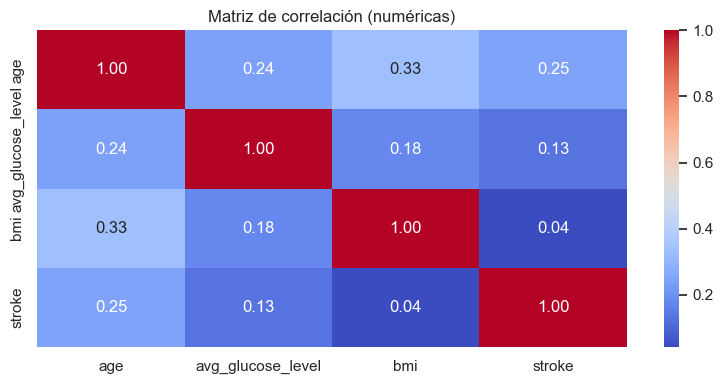

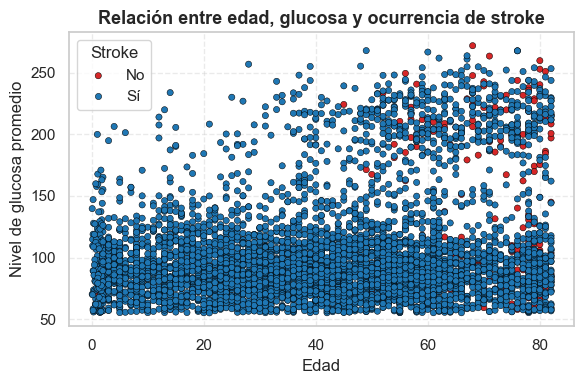

In [9]:
plt.figure(figsize=(8, 4))
corr = df[num_vars + ['stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (numéricas)')
plt.tight_layout()
plt.show()

# Relacion entre edad y nivel de glucosa, coloreado por stroke
plt.figure(figsize=(6, 4)) 
sns.scatterplot(
    data=df,
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    palette={0: '#1f77b4', 1: '#d62728'},  # azul fuerte para 0, rojo intenso para 1
    alpha=1,
    edgecolor='black',
    s=20  # tamaño de puntos
)
plt.title('Relación entre edad, glucosa y ocurrencia de stroke', fontsize=13, weight='bold')
plt.xlabel('Edad')
plt.ylabel('Nivel de glucosa promedio')
plt.legend(title='Stroke', labels=['No', 'Sí'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Distribuciones categoricas vs Target

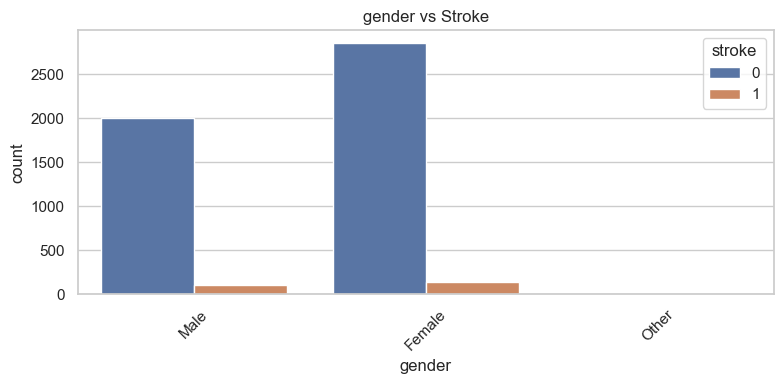

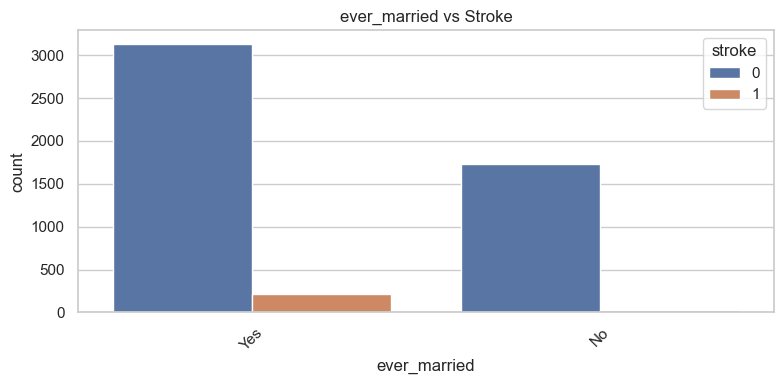

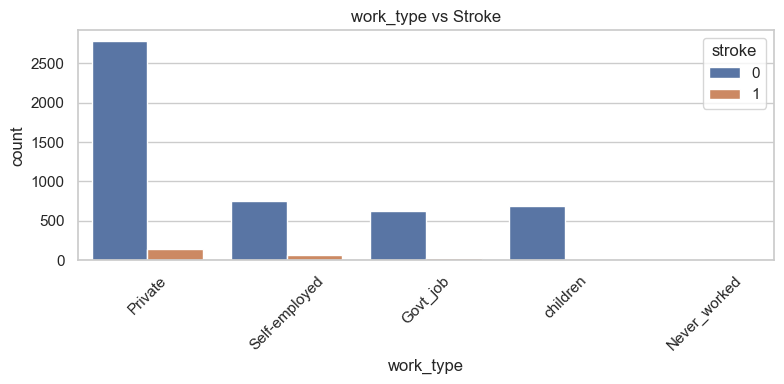

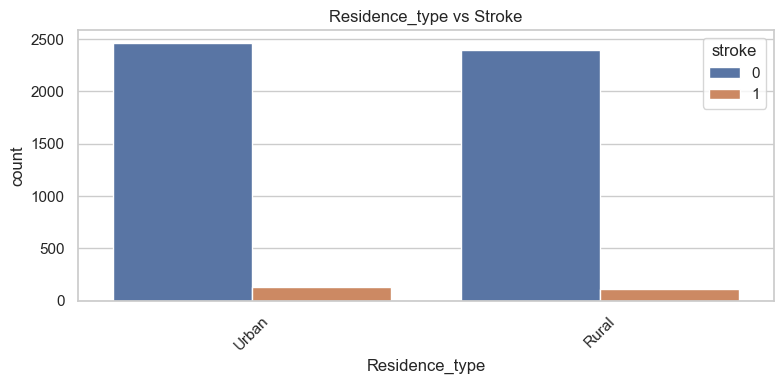

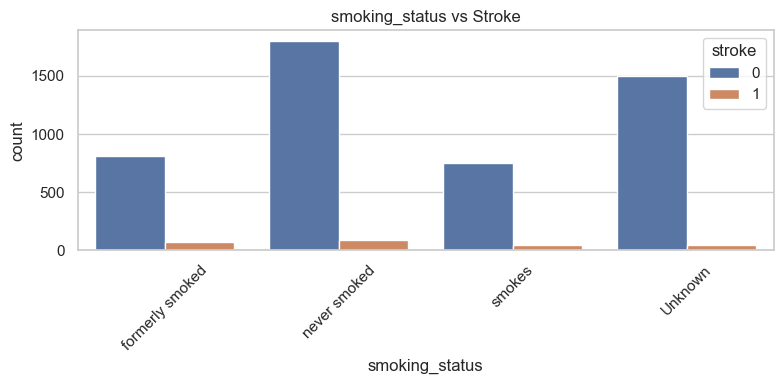

In [10]:
categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'{col} vs Stroke')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Separación entre set de entrenamiento, validación y test

Previo a las transformaciones y balanceo de los datos, se procede a crear una división entre los sets de entrenamiento, validación y test. StratifiedKFold hace los folds para validación de hiperparámetros. El set de validación se usa para encontrar el threshold óptimo y test para evaluar el modelo definitivo.

In [11]:
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

# Primero: train + valid vs test
X_temp_rf, X_test_rf, y_temp_rf, y_test_rf = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.15/0.85, stratify=y_temp_rf)


# Transformaciones y tratamiento de Nulls

Con el objetivo de proveer datos numericos y validos al modelo de entrenamiento, utilizamos la media para rellenar los valores de BMI y most_frequent para las variables categoricas. Luego escalamos los valores numericos y aplicamos One-Hot encoding a las variables categoricas dado que tienen una baja cardinalidad.

In [12]:
df['bmi'] = df['bmi'].replace('N/A', np.nan).astype(float)

num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = ['gender', 'hypertension', 'heart_disease',
                'ever_married', 'Residence_type',
                'smoking_status', 'work_type']

# se imputan valores faltantes con median + escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# se imputan valores faltantes + One-Hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Random Forest
Características:
* Maneja naturalmente tanto variables numéricas como categóricas sin requerir transformaciones complejas.
* Captura relaciones no lineales entre variables clínicas (edad, glucosa, BMI, etc.) gracias a la estructura basada en múltiples árboles.
* Es un modelo robusto al ruido, a valores atípicos y a diferencias de escala entre las variables.
* Tolera bien el desbalance de clases mediante el parámetro class_weight='balanced', lo cual ayuda a no ignorar los casos positivos de stroke.
* Ofrece un buen compromiso entre interpretabilidad, precisión, robustez y capacidad de generalización.

In [28]:
# Modelo y pipeline

modelo_rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_rf)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_rf = {
    # cantidad de arboles
    'clf__n_estimators': [200, 400, 600],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10, 15],
    'clf__min_samples_leaf': [1, 2, 4, 6],
    # numero de features en cada split
    'clf__max_features': ['sqrt', 'log2'],
    # se agrega para castigar los falsos negativos, importante en algunos casos clinicos
    'clf__class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 100 combinaciones aleatorias de parámetros
random_search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=parametros_rf,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train_rf, y_train_rf)

print("Mejores hiperparámetros Random Forest:")
print(random_search_rf.best_params_)

best_rf = random_search_rf.best_estimator_

# Evaluación en VALIDACIÓN
y_pred_val = best_rf.predict(X_val_rf)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores hiperparámetros Random Forest:
{'clf__n_estimators': 600, 'clf__min_samples_split': 15, 'clf__min_samples_leaf': 6, 'clf__max_features': 'log2', 'clf__max_depth': 5, 'clf__class_weight': 'balanced'}


In [14]:
# Determinación del mejor umbral

y_proba_val_rf = best_rf.predict_proba(X_val_rf)[:, 1]

best_threshold, best_f2 = find_threshold(y_val_rf, y_proba_val_rf)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2:.4f}")

Mejor threshold en VALIDACIÓN: 0.596
F2 en VALIDACIÓN con ese threshold: 0.3947


In [15]:
# Se entrena el modelo y predecimos
y_proba_test_rf = best_rf.predict_proba(X_test_rf)[:, 1]
threshold_rf = best_threshold
y_pred_test_rf = (y_proba_test_rf >= threshold_rf).astype(int)

# KNN
Características:
* Es un modelo basado en proximidad: clasifica un paciente según la similitud con otros casos cercanos en el espacio de características.
* No asume ninguna forma funcional ni relación lineal entre variables, lo que lo convierte en un método flexible para detectar patrones locales en los datos.
* Su funcionamiento es sencillo de interpretar: la predicción depende directamente de los vecinos más próximos, lo que facilita la explicación del resultado.
* Sensible a la escala de las variables, por lo que requiere una estandarización previa para que ninguna feature domine las distancias.
* Puede capturar relaciones complejas entre las variables clínicas (edad, glucosa, BMI, etc.) cuando existen agrupamientos naturales en los datos.
* Requiere seleccionar adecuadamente el número de vecinos (*k*) y el tipo de distancia, ya que un k demasiado bajo genera ruido y uno demasiado alto diluye la señal.
* No maneja bien el desbalance de clases de forma nativa, lo que puede causar que los casos positivos (poco frecuentes) queden eclipsados por la mayoría negativa.
* Computacionalmente costoso para grandes volúmenes de datos, ya que evalúa distancias contra todas las muestras de entrenamiento.

In [ ]:
# Primero: train + valid vs test
X_temp_knn, X_test_knn, y_temp_knn, y_test_knn = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.15/0.85, stratify=y_temp_knn)

In [17]:
modelo_knn = KNeighborsClassifier()

pipe_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_knn)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2],                  # 1 = Manhattan, 2 = Euclídea
    'clf__leaf_size': [10, 20, 30, 40, 50],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree']
}

cv_knn = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

random_search_knn = RandomizedSearchCV(
    estimator=pipe_knn,
    param_distributions=parametros_grid_knn,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv_knn,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_knn.fit(X_train_knn, y_train_knn)

best_knn = random_search_knn.best_estimator_

print("Mejores hiperparámetros KNN:")
print(random_search_knn.best_params_)

y_pred_val_knn = best_knn.predict(X_val_knn)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores hiperparámetros KNN:
{'clf__weights': 'uniform', 'clf__p': 2, 'clf__n_neighbors': 21, 'clf__leaf_size': 20, 'clf__algorithm': 'kd_tree'}


In [18]:
y_proba_val_knn = best_knn.predict_proba(X_val_knn)[:, 1]

best_threshold_knn, best_f2_knn = find_threshold(y_val_knn, y_proba_val_knn)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold_knn:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2_knn:.4f}")

y_proba_test_knn = best_knn.predict_proba(X_test_knn)[:, 1]
threshold = best_threshold_knn
y_pred_test_knn = (y_proba_test_knn >= threshold).astype(int)

Mejor threshold en VALIDACIÓN: 0.384
F2 en VALIDACIÓN con ese threshold: 0.3613


# CatBoost
Características:
* Es un modelo de gradient boosting diseñado específicamente para trabajar con variables categóricas sin necesidad de One-Hot Encoding, gracias a su técnica de *Target-Based Encoding* controlada para evitar overfitting.
* Captura relaciones no lineales complejas entre las variables, lo que lo vuelve especialmente adecuado para datos tabulares con interacciones sutiles.
* Maneja bien valores faltantes y reduce la necesidad de preprocesamiento manual.
* Ofrece una gran estabilidad respecto al desbalance de clases mediante el parámetro `class_weights`, permitiendo ajustar la penalización de falsos negativos.
* Suele converger rápidamente y con menos tuning que otros modelos de boosting, como XGBoost o LightGBM.
* Tiende a obtener un rendimiento competitivo incluso en datasets pequeños o medianos, como es el caso del presente estudio.
* Presenta un buen equilibrio entre capacidad predictiva y eficiencia computacional, siendo uno de los algoritmos más robustos para problemas tabulares con variables mixtas.


In [29]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Primero: train + valid vs test
X_temp_cat, X_test_cat, y_temp_cat, y_test_cat = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_temp_cat, y_temp_cat, test_size=0.15/0.85, stratify=y_temp_cat)

#Inicializo CatBoost
modelo_catboost = CatBoostClassifier(
    random_state=41,
    verbose=False,
    allow_writing_files=False # para evitar la creación de carpetas catboost_info
)

pipe_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_catboost)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_cat = {
    # n_estimators -> iterations
    'clf__iterations': [100, 250, 400],
    # max_depth -> depth
    'clf__depth': [4, 6, 8],
    # learning_rate
    'clf__learning_rate': [0.01, 0.05, 0.1],
    # min_samples_leaf
    'clf__min_data_in_leaf': [1, 5, 10],
    # Regularización L2
    'clf__l2_leaf_reg': [1, 3, 5, 7],
    # Pesos
    'clf__class_weights': [{0: 1, 1: 3}, {0: 1, 1: 5}]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 125 combinaciones aleatorias de parámetros
random_search_cat = RandomizedSearchCV(
    estimator=pipe_cat,
    param_distributions=parametros_grid_cat,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


random_search_cat.fit(X_train_cat, y_train_cat)

best_cat = random_search_cat.best_estimator_

print("Mejores hiperparámetros XGBoost:")
print(random_search_cat.best_params_)

# Evaluación en VALIDACIÓN
y_pred_val = best_cat.predict(X_val_cat)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores hiperparámetros XGBoost:
{'clf__min_data_in_leaf': 10, 'clf__learning_rate': 0.01, 'clf__l2_leaf_reg': 5, 'clf__iterations': 100, 'clf__depth': 8, 'clf__class_weights': {0: 1, 1: 3}}


In [20]:
y_proba_val_cat = best_cat.predict_proba(X_val_cat)[:, 1]

best_threshold_cat, best_f2_cat = find_threshold(y_val_cat, y_proba_val_cat)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold_cat:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2_cat:.4f}")

y_proba_test_cat = best_cat.predict_proba(X_test_cat)[:, 1]
threshold = best_threshold_cat
y_pred_test_cat = (y_proba_test_cat >= threshold).astype(int)

Mejor threshold en VALIDACIÓN: 0.591
F2 en VALIDACIÓN con ese threshold: 0.3655


# XGBoost
Características:
* Es un modelo basado en árboles que maneja naturalmente relaciones no lineales entre las variables sin necesidad de ingeniería de features adicional.
* Suele obtener mejor rendimiento que Random Forest en datos tabulares gracias al boosting, que corrige iterativamente los errores de los árboles anteriores.
* Permite un control fino del sobreajuste mediante hiperparámetros como learning_rate, max_depth y gamma.
* Se adapta bien al desbalance de clases mediante el parámetro scale_pos_weight, y puede combinarse con SMOTE dentro del pipeline.
* Mantiene buena robustez frente a ruido y valores extremos

In [21]:
X_temp_xgb, X_test_xgb, y_temp_xgb, y_test_xgb = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_temp_xgb, y_temp_xgb, test_size=0.15/0.85, stratify=y_temp_xgb)

# Modelo y pipeline
modelo_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=5, random_state=42)),
    ('clf', modelo_xgb)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_xgb = {
    'clf__n_estimators': [100, 200, 300, 500, 800],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.001, 0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__min_child_weight': [1, 3, 5],
    'clf__gamma': [0, 1, 3, 5],
    'clf__scale_pos_weight': [1, 3, 5, 10]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#probamos con 125 combinaciones aleatorias de parámetros
random_search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=parametros_grid_xgb,
    n_iter=200,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train_xgb, y_train_xgb)

best_xgb = random_search_xgb.best_estimator_

print("Mejores hiperparámetros XGBoost:")
print(random_search_xgb.best_params_)

# Evaluación en VALIDACIÓN
y_pred_val = best_xgb.predict(X_val_xgb)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores hiperparámetros XGBoost:
{'clf__subsample': 0.6, 'clf__scale_pos_weight': 1, 'clf__n_estimators': 800, 'clf__min_child_weight': 3, 'clf__max_depth': 5, 'clf__learning_rate': 0.001, 'clf__gamma': 3, 'clf__colsample_bytree': 0.8}


In [22]:
# Determinación del mejor umbral
y_proba_val_xgb = best_xgb.predict_proba(X_val_xgb)[:, 1]

best_threshold_xgb, best_f2_xgb = find_threshold(y_val_xgb, y_proba_val_xgb)
print(f"Mejor threshold en VALIDACIÓN: {best_threshold_xgb:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2_xgb:.4f}")

# Se entrena el modelo y predecimos
y_proba_test_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]
threshold = best_threshold_xgb
y_pred_test_xgb = (y_proba_test_xgb >= threshold).astype(int)

Mejor threshold en VALIDACIÓN: 0.488
F2 en VALIDACIÓN con ese threshold: 0.3900


# Métricas comparativas

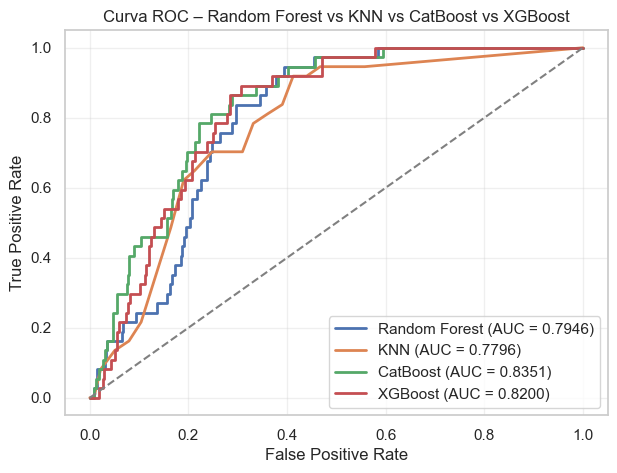

In [23]:
# Cálculo ROC de Random Forest
roc_auc_rf = roc_auc_score(y_test_rf, y_proba_test_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_proba_test_rf)

# Cálculo ROC de KNN
roc_auc_knn = roc_auc_score(y_test_knn, y_proba_test_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_test_knn, y_proba_test_knn)

# Cálculo ROC de CatBoost
roc_auc_cat = roc_auc_score(y_test_cat, y_proba_test_cat)
fpr_cat, tpr_cat, _ = roc_curve(y_test_cat, y_proba_test_cat)

# Cálculo ROC de XGBoost
roc_auc_xgb = roc_auc_score(y_test_xgb, y_proba_test_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_xgb, y_proba_test_xgb)

plt.figure(figsize=(7, 5))

# RF
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", linewidth=2)

# RF
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_knn:.4f})", linewidth=2)

# RF
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {roc_auc_cat:.4f})", linewidth=2)

# XGB
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})", linewidth=2)

# Diagonal
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Random Forest vs KNN vs CatBoost vs XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

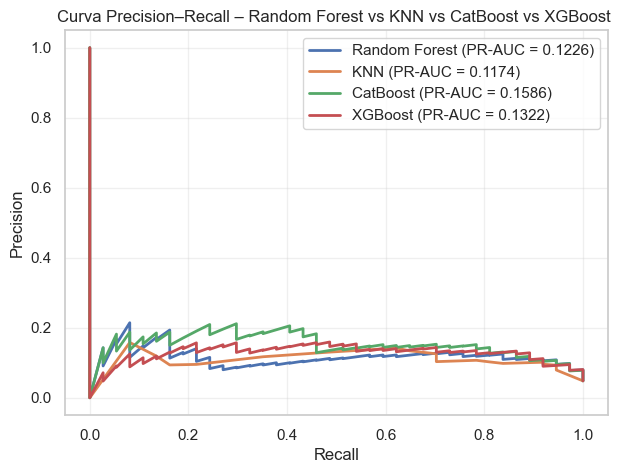

In [24]:
# PR Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test_rf, y_proba_test_rf)
pr_auc_rf = average_precision_score(y_test_rf, y_proba_test_rf)

# PR KNN
precision_knn, recall_knn, _ = precision_recall_curve(y_test_knn, y_proba_test_knn)
pr_auc_knn = average_precision_score(y_test_knn, y_proba_test_knn)

# PR CatBoost
precision_cat, recall_cat, _ = precision_recall_curve(y_test_cat, y_proba_test_cat)
pr_auc_cat = average_precision_score(y_test_cat, y_proba_test_cat)

# PR XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test_xgb, y_proba_test_xgb)
pr_auc_xgb = average_precision_score(y_test_xgb, y_proba_test_xgb)

plt.figure(figsize=(7, 5))

plt.plot(recall_rf, precision_rf, label=f"Random Forest (PR-AUC = {pr_auc_rf:.4f})", linewidth=2)
plt.plot(recall_knn, precision_knn, label=f"KNN (PR-AUC = {pr_auc_knn:.4f})", linewidth=2)
plt.plot(recall_cat, precision_cat, label=f"CatBoost (PR-AUC = {pr_auc_cat:.4f})", linewidth=2)
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (PR-AUC = {pr_auc_xgb:.4f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall – Random Forest vs KNN vs CatBoost vs XGBoost ")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

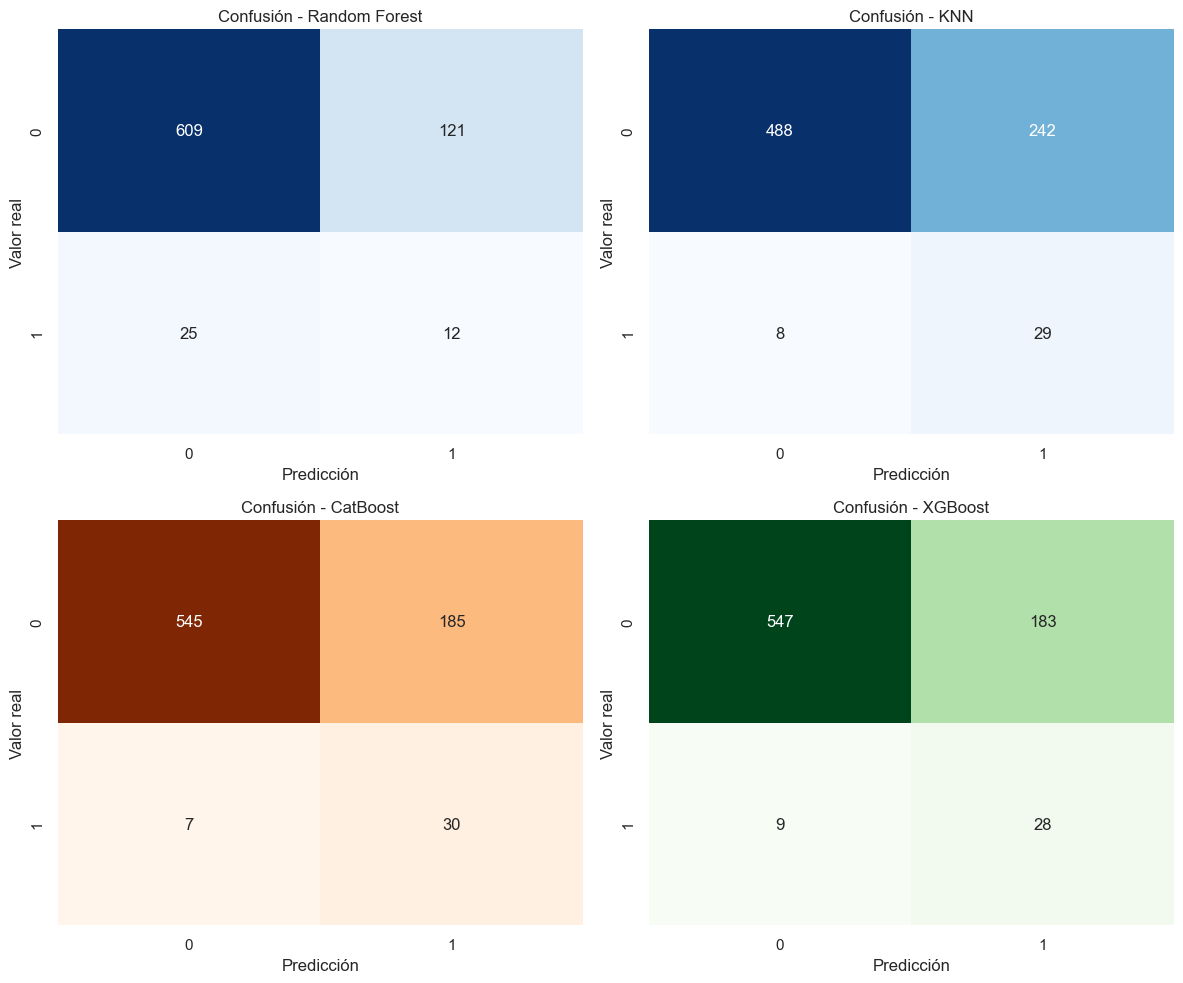

In [25]:
# Matrices de confusión
cm_rf = confusion_matrix(y_test_rf, y_pred_test_rf)
cm_knn = confusion_matrix(y_test_knn, y_pred_test_knn)
cm_cat = confusion_matrix(y_test_cat, y_pred_test_cat)
cm_xgb = confusion_matrix(y_test_xgb, y_pred_test_xgb)

# Crear figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0, 0])
axes[0, 0].set_title("Confusión - Random Forest")
axes[0, 0].set_xlabel("Predicción")
axes[0, 0].set_ylabel("Valor real")

# KNN
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0, 1])
axes[0, 1].set_title("Confusión - KNN")
axes[0, 1].set_xlabel("Predicción")
axes[0, 1].set_ylabel("Valor real")

# CatBoost
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Oranges", cbar=False, ax=axes[1, 0])
axes[1, 0].set_title("Confusión - CatBoost")
axes[1, 0].set_xlabel("Predicción")
axes[1, 0].set_ylabel("Valor real")

# XGBoost
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1, 1])
axes[1, 1].set_title("Confusión - XGBoost")
axes[1, 1].set_xlabel("Predicción")
axes[1, 1].set_ylabel("Valor real")

plt.tight_layout()
plt.show()


In [26]:
def regression_metrics(y_true, y_proba):
    mae = mean_absolute_error(y_true, y_proba)
    rmse = np.sqrt(mean_squared_error(y_true, y_proba))

    # MAPE: evitar división por cero
    eps = 1e-6
    mape = np.mean(np.abs((y_true - y_proba) / (y_true + eps))) * 100

    r2 = r2_score(y_true, y_proba)

    return mae, rmse, mape, r2

metrics_rf  = regression_metrics(y_test_rf,  y_proba_test_rf)
metrics_knn = regression_metrics(y_test_knn, y_proba_test_knn)
metrics_cat = regression_metrics(y_test_cat, y_proba_test_cat)
metrics_xgb = regression_metrics(y_test_xgb, y_proba_test_xgb)

df_metrics = pd.DataFrame(
    [metrics_rf, metrics_knn, metrics_cat, metrics_xgb],
    columns=["MAE", "RMSE", "MAPE (%)", "R²"],
    index=["Random Forest", "KNN", "CatBoost", "XGBoost"]
)

df_metrics


,MAE,RMSE,MAPE (%),R²
Random Forest,0.320846,0.393658,2.994213e+07,-2.375238
KNN,0.280934,0.424189,2.622462e+07,-2.919093
CatBoost,0.317999,0.429141,3.030852e+07,-3.011128
XGBoost,0.380818,0.406448,3.591445e+07,-2.598129


# ¿Qué pasa si calibramos RF?


Mejor threshold (calibrado) en VALIDACIÓN: 0.0888
Mejor F2 en VALIDACIÓN (calibrado): 0.3783

=== Random Forest calibrado - MÉTRICAS EN TEST ===
ROC-AUC        : 0.7918
PR-AUC         : 0.1268
Brier score    : 0.0441

Reporte de clasificación (umbral calibrado):
              precision    recall  f1-score   support

           0     0.9664    0.7877    0.8679       730
           1     0.0988    0.4595    0.1627        37

    accuracy                         0.7718       767
   macro avg     0.5326    0.6236    0.5153       767
weighted avg     0.9245    0.7718    0.8339       767

Matriz de confusión (umbral calibrado):
[[575 155]
 [ 20  17]]


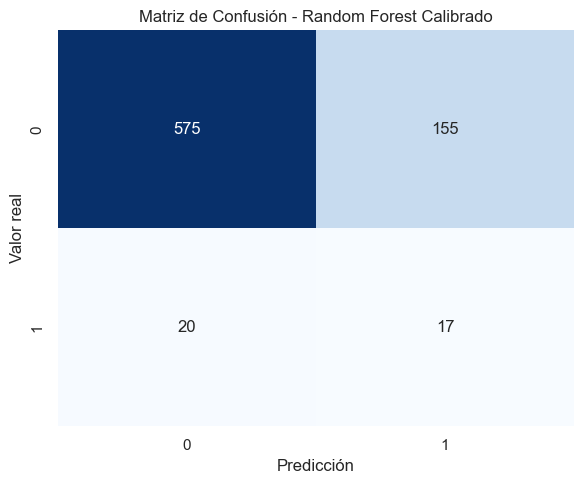

In [27]:
rf_cal = CalibratedClassifierCV(
    estimator=best_rf,   # tu pipeline preprocessor + smote + RF
    cv=5,
    method='sigmoid'
)

# calibramos solo con el TRAIN para evitar leakage
rf_cal.fit(X_train_rf, y_train_rf)

y_proba_val_cal = rf_cal.predict_proba(X_val_rf)[:, 1]

best_threshold_cal, best_f2_cal = find_threshold(y_val_rf, y_proba_val_cal)

print(f"\nMejor threshold (calibrado) en VALIDACIÓN: {best_threshold_cal:.4f}")
print(f"Mejor F2 en VALIDACIÓN (calibrado): {best_f2_cal:.4f}")

y_proba_test_cal = rf_cal.predict_proba(X_test_rf)[:, 1]
y_pred_test_cal  = (y_proba_test_cal >= best_threshold_cal).astype(int)

roc_auc_cal  = roc_auc_score(y_test_rf, y_proba_test_cal)
pr_auc_cal   = average_precision_score(y_test_rf, y_proba_test_cal)
brier_cal    = brier_score_loss(y_test_rf, y_proba_test_cal)

print("\n=== Random Forest calibrado - MÉTRICAS EN TEST ===")
print(f"ROC-AUC        : {roc_auc_cal:.4f}")
print(f"PR-AUC         : {pr_auc_cal:.4f}")
print(f"Brier score    : {brier_cal:.4f}")

print("\nReporte de clasificación (umbral calibrado):")
print(classification_report(y_test_rf, y_pred_test_cal, digits=4, zero_division=0))

cm_cal = confusion_matrix(y_test_rf, y_pred_test_cal)

print("Matriz de confusión (umbral calibrado):")
print(cm_cal)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_cal, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión - Random Forest Calibrado")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.tight_layout()
plt.show()

## Conclusión

El objetivo del trabajo fue construir y evaluar distintos modelos de Machine Learning para predecir la probabilidad de ocurrencia de un accidente cerebrovascular (ACV) utilizando variables demográficas, clínicas y de hábitos. Se trabajó sobre un dataset altamente desbalanceado (≈95% clase negativa, 5% positiva), lo que implica un riesgo elevado de falsos negativos. En un contexto médico, donde omitir un caso positivo puede impedir una intervención temprana, se priorizó explícitamente maximizar el recall aun si esto incrementaba los falsos positivos.

## Preparación y Preprocesamiento

#### Se realizaron los siguientes pasos:
- Imputación de valores faltantes (numéricos por mediana, categóricos por moda).
- Estandarización de variables numéricas y One-Hot Encoding para las categóricas.
- Inclusión de SMOTE solo en el conjunto de entrenamiento, evitando data leakage y permitiendo que los modelos aprendan patrones de la clase minoritaria.
- Evaluación de diferentes esquemas de `class_weight` para mitigar el desbalance.
- Separación estricta entre *train*, *validation* y *test* para garantizar una evaluación honesta del desempeño.

## Entrenamiento, tuning y calibración

El modelo principal explorado fue Random Forest, comparado con KNN, CatBoost y XGBoost.  
La búsqueda de hiperparámetros se realizó mediante RandomizedSearchCV utilizando F2-score como métrica objetivo, debido a que penaliza más los falsos negativos.

Se probó calibración de probabilidades mediante Platt scaling (sigmoid), cuyo objetivo es mejorar la probabilidad predicha y reducir el Brier Score. Sin embargo, la calibración no necesariamente mejora la sensibilidad en datasets altamente desbalanceados.

## Resultados y comparación de modelos

A partir de las nuevas matrices de confusión:

### Random Forest
- TN = 609  
- FP = 121  
- FN = 25  
- TP = 12  

RF mantiene la mejor relación entre recall y estabilidad general, aunque todavía genera falsos negativos.

### KNN
- FN = 8  
- Pero su FP aumenta muchísimo y sus métricas globales de discriminación (ROC, PR-AUC) son inferiores.  
- Es decir, identifica positivos pero pierde capacidad discriminativa general.

### CatBoost
- FN = 7 (el más bajo entre los modelos)
- Pero a costa de 185 falsos positivos, lo que reduce su utilidad práctica si se necesita un balance razonable entre sensibilidad y costo de sobre-alertas.

### XGBoost
- FN = 9  
- FP = 183  
- Buen AUC pero menos estable que RF y peor calibración.

### Calibración (MAE, RMSE, R²)

Los cuatro modelos mostraron métricas de calibración pobres:

- R² negativo en todos los casos, indicando que las probabilidades predichas no representan bien la variabilidad real de la clase.
- MAE y RMSE altos para todos, especialmente XGBoost.
- Este comportamiento es esperado: modelos basados en árboles suelen ser malas estimadoras de probabilidad sin calibración adicional, y el fuerte desbalance empeora el panorama.

La calibración no mejoró el recall y, en algunos casos, lo empeoró. Por ello, no es la técnica adecuada para este objetivo clínico específico.

## Conclusión final

Tomando en cuenta las nuevas métricas obtenidas:

- Random Forest sin calibrar, entrenado con SMOTE, optimizado con F2-score y con ajuste de umbral, sigue siendo la mejor alternativa global.
- Ofrece el mejor equilibrio entre:
  - sensibilidad adecuada,
  - estabilidad en la discriminación,
  - menor tasa de falsos positivos en comparación con CatBoost y XGBoost,
  - comportamiento más consistente que KNN.

Aunque CatBoost logró el menor número de falsos negativos, lo hizo a costa de un incremento muy alto en falsos positivos, lo que reduce su utilidad práctica en un escenario clínico real, donde se busca sensibilidad pero con un mínimo de ruido operativo.

### Modelo recomendado
- Random Forest optimizado y con threshold ajustado (no calibrado)  
  Es el modelo más coherente con el objetivo clínico del proyecto:  
  minimizar falsos negativos manteniendo un nivel razonable de falsos positivos.

En resumen, Random Forest constituye la solución más robusta, estable y alineada con la prioridad médica del problema, a pesar del desbalance severo del dataset y la dificultad inherente del caso clínico.

A la par, algo que seria muy interesante es probar utilizando un modelo de Deep Learning y comparar los resultados con los que se entrenaron en este trabajo. Sin embargo, esto escapa el alcance de la materia.